In [6]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from scipy.stats import mode
from astropy.io import ascii

## Generate Master Darks and Flat

In [7]:
# Load fits files for 2s and 1.5s dark exposures, use ms values for naming consistency
dark_1500ms = []
dark_2000ms = []
flats = []

# Make list of 2s dark data
for i in range(0,10):
    fname = '../data/dark_R_2s.0000000{0}.DARK.FIT'.format(i+1)
    try: 
        file = fits.open(fname)
    except FileNotFoundError:
        fname = fits.open('../data/dark_R_2s.00000010.DARK.FIT')
    dark_2000ms.append(file[0].data)
    file.close()

# 1.5s dark data 
for i in range(10,20):
    fname = '../data/dark_R_1.5s.000000{0}.DARK.FIT'.format(i+1)
    file = fits.open(fname)
    dark_1500ms.append(file[0].data)
    file.close()

# Flats data
for i in range(0,10):
    fname = '../data/flat_R.0000000{0}.FIT'.format(i+1)
    try: 
        file = fits.open(fname)
    except FileNotFoundError:
        fname = fits.open('../data/flat_R.00000010.FIT')
    flats.append(file[0].data)
    file.close()
    
m_dark_1500ms = np.empty(shape=dark_1500ms[0].shape)       # Make blank arrays of 1024 by 1024
m_dark_2000ms = np.empty(shape=dark_2000ms[0].shape)
m_flat = np.zeros(shape=flats[0].shape)
for y in range(1024):                          # For each y value
    for x in range(1024):                      # and each x value
        pixel_val_1500ms = []                             
        pixel_val_2000ms = []
        pixel_val_flat = []
        for dark in dark_1500ms:                           # and every frame
            pixel_val_1500ms.append(dark[y][x])     # Make a list of the value in the y,x pixel for 1.5s darks
        for dark in dark_2000ms:                              
            pixel_val_2000ms.append(dark[y][x])     # and the 2s darks
        for flat in flats:
            pixel_val_flat.append(flat[y][x])              # and the flats

        m_dark_1500ms[y][x] = np.median(pixel_val_1500ms)  # And store median value to the y,x pixel of the right master
        m_dark_2000ms[y][x] = np.median(pixel_val_2000ms)
        m_flat[y][x] = np.median(pixel_val_flat)
        
# Normalize master flat to have relative intensities varying around 1
m_flat /= np.mean(m_flat)

## Apply master fields to science images

In [53]:
'''
# Process science images with flats and darks (subtract dark, divide by flat)
# Comment this block out once run the first time, processing intensive and only needs to be done once to make the files

# Change working directory for processed data
os.chdir('../jupyter/')
print(os.getcwd())
os.chdir('../processed_data/')
print(os.getcwd())

# File extensions
files2000ms = np.array([*range(1, 902)])
files1500ms = np.array([*range(1001, 1193)])
files1500ms = np.append(files1500ms, [*range(2001, 3177)])
sequential_data = []
series = 0                                                               # Keep sequential file numbers
for i in files2000ms:
    file = fits.open('../data/hd209458_R_2s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    test_file = fits.PrimaryHDU((file[0].data-m_dark_2000ms)/m_flat)
    test_file.writeto('hd209458_processed_{}.fits'.format(str(series).zfill(5)), overwrite=True)
    file.close()
    series += 1
for i in files1500ms:
    file = fits.open('../data/hd209458_R_1_5s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    test_file = fits.PrimaryHDU((file[0].data-m_dark_1500ms)/m_flat)
    test_file.writeto('hd209458_processed_{}.fits'.format(str(series).zfill(5)), overwrite=True)
    file.close()
    series += 1

#'''

# Also make a list of the DATE-OBS keywords for each file in order

files2000ms = np.array([*range(1, 902)])
files1500ms = np.array([*range(1001, 1193)])
files1500ms = np.append(files1500ms, [*range(2001, 3177)])

observation_dates = np.array([])
for i in files2000ms:
    file = fits.open('../data/hd209458_R_2s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))
    date = file[0].header['DATE-OBS']
    observation_dates = np.append(observation_dates, date)
    file.close()
for i in files1500ms:
    file = fits.open('../data/hd209458_R_1_5s_start_series1000.0000{}.FIT'.format(str(i).zfill(4)))   
    date = file[0].header['DATE-OBS']
    observation_dates = np.append(observation_dates, date)
    file.close()
    
print(observation_dates)
print(len(observation_dates))

['2019-09-18T02:08:44.614' '2019-09-18T02:08:51.128'
 '2019-09-18T02:08:57.642' ... '2019-09-18T06:27:09.671'
 '2019-09-18T06:27:16.606' '2019-09-18T06:27:23.527']
2269


## Bad Pixel Map

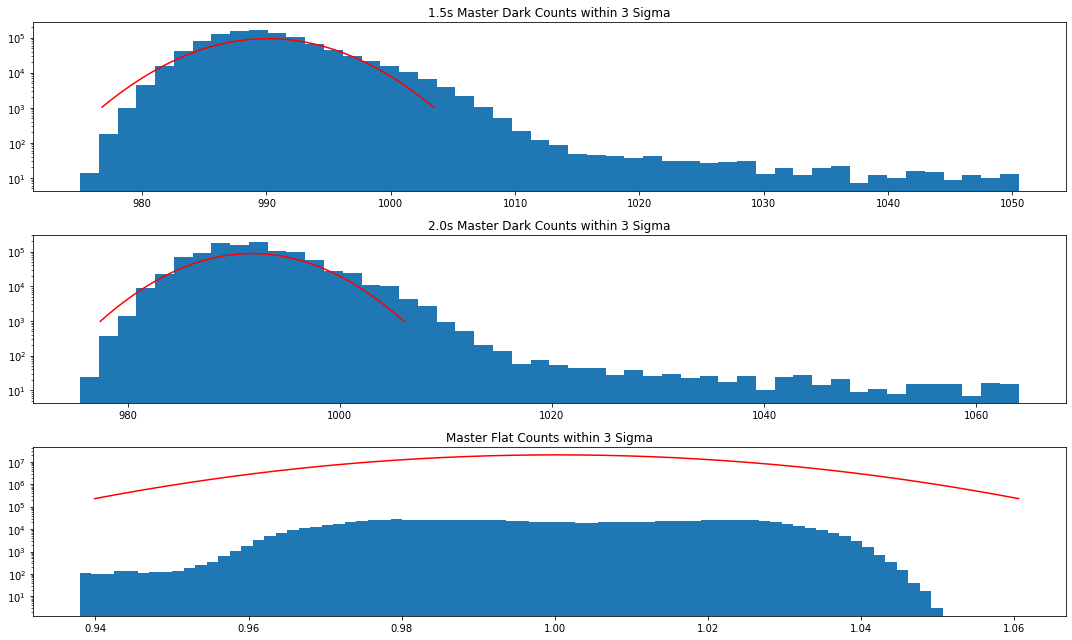

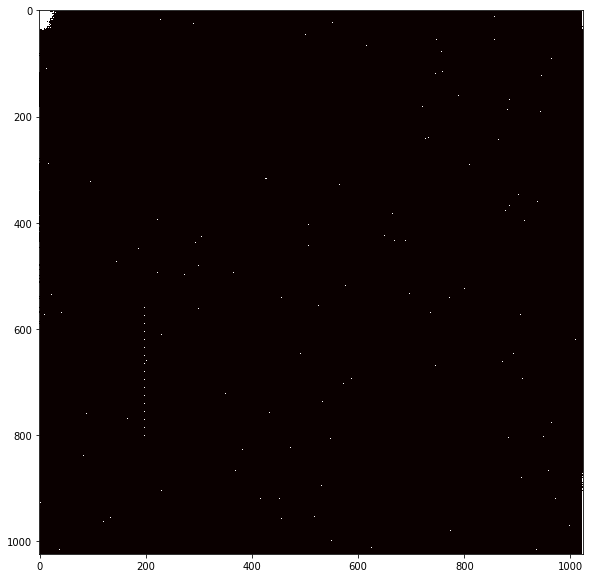

In [9]:
# Find stats for masters
flat_mean = np.mean(m_flat)
dark_mean1500 = np.mean(m_dark_1500ms)
dark_mean2000 = np.mean(m_dark_2000ms)
flat_std = np.std(m_flat)
dark_std1500 = np.std(m_dark_1500ms)
dark_std2000 = np.std(m_dark_2000ms)

# Significance level for cuts ------------------------------------------------- EDITABLE FOR VARIOUS NEEDS
siglevel = 3

# Define a gaussian function
def gaussian(mu, std):
    x = np.linspace(mu-siglevel*std, mu+siglevel*std, 200)
    func = np.exp(-pow((x-mu)/std, 2)/2)
    func /= np.sqrt(2*np.pi*std*std)
    func *= 1024*1024
    return x, func

# Cur the data to be within  sigma
dark_1500ms_cut = [x for x in m_dark_1500ms.flatten() if x < dark_mean1500+siglevel*dark_std1500 
                   and x > dark_mean1500-siglevel*dark_std1500]
dark_2000ms_cut = [x for x in m_dark_2000ms.flatten() if x < dark_mean2000+siglevel*dark_std2000 
                   and x > dark_mean2000-siglevel*dark_std2000]
flat_cut = [x for x in m_flat.flatten() if x < flat_mean+siglevel*flat_std and x > flat_mean-siglevel*flat_std]

# Plot histograms
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.hist(dark_1500ms_cut, log=True, bins=50)
ax2.hist(dark_2000ms_cut, log=True, bins=50)
ax3.hist(flat_cut, log=True, bins=75)
ax1.set_title('1.5s Master Dark Counts within 3 Sigma')
ax2.set_title('2.0s Master Dark Counts within 3 Sigma')
ax3.set_title('Master Flat Counts within 3 Sigma')
ax1.plot(*gaussian(np.mean(dark_1500ms_cut), np.std(dark_1500ms_cut)), 'r-')
ax2.plot(*gaussian(np.mean(dark_2000ms_cut), np.std(dark_2000ms_cut)), 'r-')
ax3.plot(*gaussian(np.mean(flat_cut), np.std(flat_cut)), 'r-')
fig.tight_layout()
plt.show()
plt.close()

# Make bad pixel map and plot
bad_pixel_map = np.ones(shape=(1024, 1024))
for y in range(1024):
    for x in range(1024):
        if (m_dark_1500ms[y][x] > dark_mean1500+siglevel*dark_std1500 or 
            m_dark_1500ms[y][x] < dark_mean1500-siglevel*dark_std1500):
            bad_pixel_map[y][x] = 0
        elif (m_dark_2000ms[y][x] > dark_mean2000+siglevel*dark_std2000 or 
              m_dark_2000ms[y][x] < dark_mean2000-siglevel*dark_std2000):
            bad_pixel_map[y][x] = 0
        elif m_flat[y][x] > flat_mean+siglevel*flat_std or m_flat[y][x] < flat_mean-siglevel*flat_std:
            bad_pixel_map[y][x] = 0
fig = plt.figure(figsize=(10, 10))
plt.imshow(bad_pixel_map, cmap='hot_r')
plt.show()

## Reference Star Lightcurves

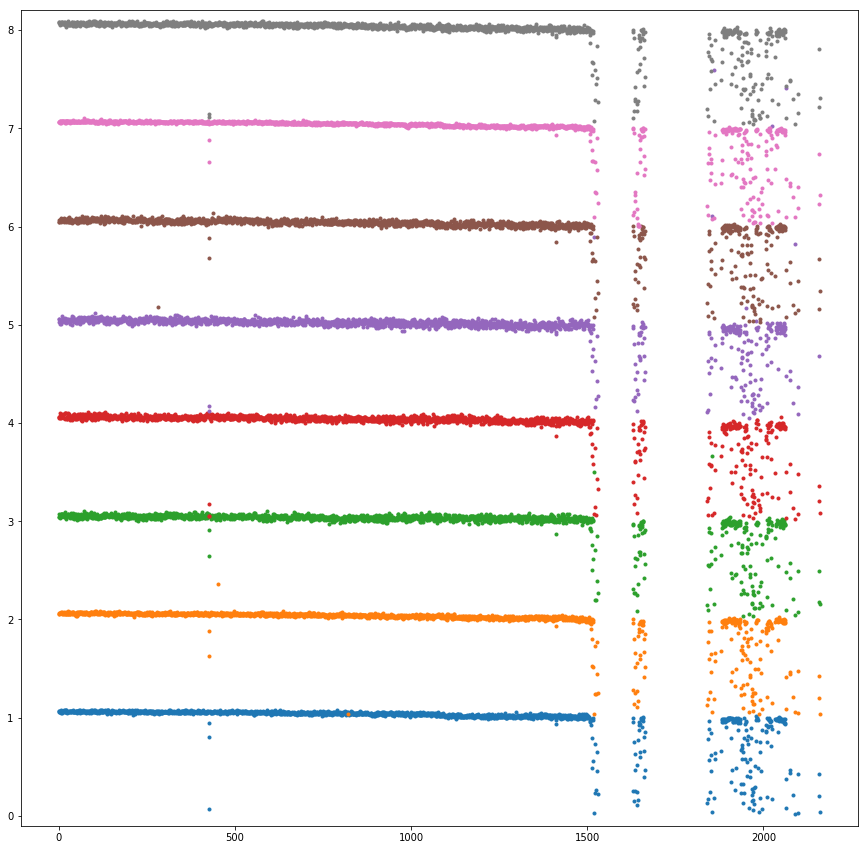

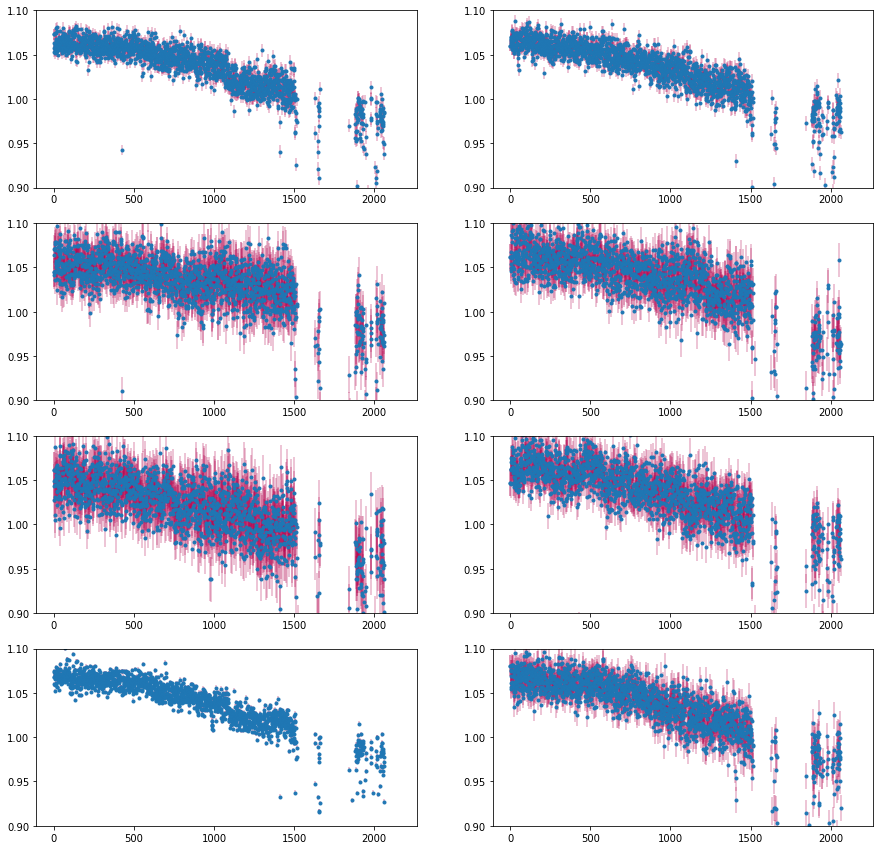

In [36]:
files = sorted(os.listdir('../lightcurve'))
files = [file for file in files if file[-4:]=='.dat']

file_2s = [file for file in files if file[-11:-10] == str(0)]      # Grab the 2s exposure catalogs
file_1_5s = [file for file in files if file[-11:-10] == str(5)]      # Grab the 1.5s exposure catalogs

fig1, ax1 = plt.subplots(1, 1, figsize=(15, 15))
fig2, ax2 = plt.subplots(4, 2, figsize=(15, 15))
ax2 = ax2.flatten()

maxfiles = 0
full_flux = []
full_err = []
for i in range(len(file_2s)):
    data1 = np.loadtxt('../lightcurve/{0}'.format(file_2s[i]), skiprows=1)
    fnum1, count1, sigcount1 = data1.T
    flux1 = count1/2
    sigflux1 = sigcount1/2
    
    data2 = np.loadtxt('../lightcurve/{0}'.format(file_1_5s[i]), skiprows=1)
    fnum2, count2, sigcount2 = data2.T
    flux2 = count2/1.5
    sigflux2 = sigcount2/1.5
    
    fnum = np.append(fnum1, fnum2)
    flux = np.append(flux1, flux2)
    sigflux = np.append(sigflux1, sigflux2)
    
    sigflux /= np.mean(flux)
    flux /= np.mean(flux)

    ax1.plot(fnum, flux+i, '.')
    ax2[i].errorbar(fnum, flux, fmt='.', yerr=sigflux, ecolor=(0.7, 0, 0.3, 0.3))
    ax2[i].set_ylim(.9, 1.1)
    
    if maxfiles < fnum[-1:]:
        maxfiles = fnum[-1:]
        
    full_flux.append(flux)
    full_err.append(sigflux)

ax1.set_ylim(-.1, 8.2)
plt.show()

In [52]:
time = []
weighted_mean = []
weighted_mean_err = []
for i in range(1737):
    num = 0
    denom = 0
    for j in range(8):
        num += full_flux[j][i]/(full_err[j][i]**2)
        denom += 1/(full_err[j][i]**2)
    weighted_mean.append(num/denom)
    weighted_mean_err.append(np.sqrt(1/denom))
    time.append(int(observation_dates[i][11:13])+int(observation_dates[i][14:16])/60
                +float(observation_dates[i][17:])/60/60)
    
print(time)

[2.1457261111111112, 2.1475355555555553, 2.149345, 2.1511544444444444, 2.152963888888889, 2.154773611111111, 2.156578611111111, 2.1583880555555557, 2.1601974999999998, 2.1620069444444443, 2.1638155555555554, 2.165620833333333, 2.167426111111111, 2.1692355555555554, 2.171045, 2.17285, 2.1746552777777777, 2.176464722222222, 2.1782827777777776, 2.180092222222222, 2.181914722222222, 2.1837241666666665, 2.1855466666666663, 2.187356111111111, 2.1891655555555554, 2.190975, 2.1927802777777776, 2.194589722222222, 2.1963991666666667, 2.198217222222222, 2.200026666666667, 2.201836388888889, 2.2036544444444446, 2.2054683333333336, 2.207268888888889, 2.209074166666667, 2.210879166666667, 2.2126844444444447, 2.2144894444444447, 2.2162988888888893, 2.2181083333333333, 2.2199180555555555, 2.2217230555555556, 2.2235283333333333, 2.225337777777778, 2.2271558333333337, 2.2289608333333333, 2.2307705555555555, 2.232571111111111, 2.234376388888889, 2.2361858333333333, 2.237991111111111, 2.2398005555555556, 

# Lightcurve for Object Star

In [16]:
data_obj2_0=ascii.read('../lctable_star2_0.cat')
data_obj1_5=ascii.read('../lctable_star1_5.cat')
flux_obj1=data_obj2_0['FLUX_APER']/2
flux_obj2=data_obj1_5['FLUX_APER']/1.5
fluxerr_obj1=data_obj2_0['FLUXERR_APER']/2
fluxerr_obj2=data_obj1_5['FLUXERR_APER']/1.5
flux_obj=np.append(flux_obj1,flux_obj2)
fluxerr_obj=np.append(fluxerr_obj1,fluxerr_obj2)
flux_obj_rescaled=flux_obj/np.mean(flux_obj)
fluxerr_obj_rescaled=fluxerr_obj/np.mean(flux_obj)
#ratio r_i
r_i=flux_obj_rescaled/weighted_mean
rerr_i=r_i**2*((np.array(fluxerr_obj_rescaled)/np.array(flux_obj_rescaled))**2+(np.array(weighted_mean_err)/np.array(weighted_mean)**2))
